# NJ COVID-19 Case Analysis

An analysis on the number of coronivirus cases per municipality in New Jersey.

This utilizes the historical NJ Covid-19 case data from March 25, 2020 - Present collected into [this repository](https://github.com/saaqebs/covid19-newjersey). Another dataset about basic statistical information of NJ municipalities which was scraped from a [Wikipedia Article](https://en.wikipedia.org/wiki/List_of_municipalities_in_New_Jersey) that is stored in a file named `municipal.csv`.

In [1]:
from urllib import request, response, error
from matplotlib import pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import json

Functions for grabbing the data from their respective sources into a a `pandas` dataframe or dictionary.

In [2]:
def get_historical_covid_data():
    url = 'https://raw.githubusercontent.com/saaqebs/covid19-newjersey/master/nj_total.csv'
    df_historical = pd.read_csv(url)
    date_nicer = lambda x: x.replace('-2020','').replace('-',' ').capitalize()
    df_historical['Date'] = df_historical['Date'].map(date_nicer)
    df_historical = df_historical.set_index('Date')
    return df_historical

In [3]:
def get_today_covid_data():
    url = 'https://raw.githubusercontent.com/saaqebs/covid19-newjersey/master/nj_today.json'
    response = request.urlopen(url)
    todays_data = json.loads(response.read())['data']
    return todays_data

In [4]:
def get_municipal_data():
    df_municipal = pd.read_csv('data/municipal.csv')
    return df_municipal.set_index('Municipal')

Using the functions to get the data.

In [5]:
todays_covid_data = get_today_covid_data()
todays_data_counter = Counter(todays_covid_data)

In [6]:
df_historical = get_historical_covid_data()
df_municipal = get_municipal_data()

A brief overview of what the data looks like.

In [7]:
print('Top 5 NJ municipalities with highest number of COVID-19 cases:')
for town,num in todays_data_counter.most_common(5):
    print('{} : {}'.format(town.title(),num))

Top 5 NJ municipalities with highest number of COVID-19 cases:
Newark : 5805
Paterson : 5536
Jersey City : 5517
Elizabeth : 4007
Passaic : 2504


In [8]:
# Latest 5 days recorded COVID-19 data in New Jersey
df_historical.tail()

,Municipal,Cases
Date,,
May 3,oxford township,6
May 3,phillipsburg,107
May 3,pohatcong township,20
May 3,washington,42
May 3,white township,49


In [9]:
df_municipal.head()

,County,Population,Type
Municipal,,,
newark,essex,285154,city
jersey city,hudson,270753,city
paterson,passaic,148678,city
elizabeth,union,130215,city
edison,middlesex,102450,township


Functions that print out the historical data information regarding the growth in COVID-19 cases in the specified municipalities.

In [10]:
def get_graph_for_municipality(municipal):
    data = df_historical[df_historical['Municipal']==municipal.lower()]
    plt.plot(data['Cases'],linewidth=3)
    plt.xticks(np.arange(0,len(data),6))
    plt.grid(b=True, color='black',alpha=0.5,linestyle='dashed', linewidth=0.5)
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title('Tracking COVID-19 Cases in {}'.format(municipal))
    plt.show()

In [11]:
def get_graph_from_municipalities(municipals):
    lines = []
    data = []
    longest = 0
    
    for municipal in municipals:
        curr_data = df_historical[df_historical['Municipal']==municipal.lower()]
        line, = plt.plot(curr_data['Cases'],linewidth=3,label=municipal)
        
        longest = max(longest,len(curr_data))
        data.append(curr_data)
        lines.append(line)
    
    plt.legend(handles=lines, loc='upper left')
    plt.xticks(np.arange(0,longest,6))
    plt.grid(b=True, color='black',alpha=0.5,linestyle='dashed', linewidth=0.5)
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.title('Trackling COVID-19 Cases in NJ')
    plt.show()

Example graphs for the following townships: New Brunswick, South Brunswick, Piscataway, Princeton.

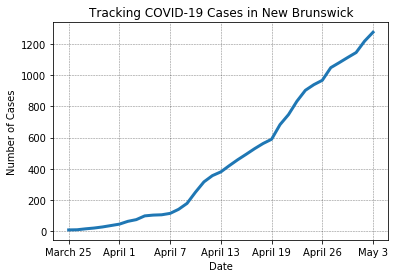

In [12]:
get_graph_for_municipality('New Brunswick')

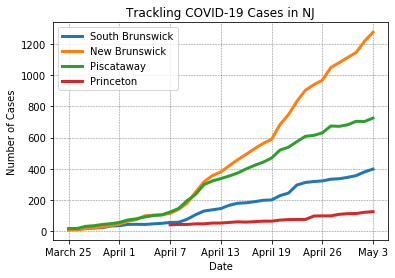

In [13]:
central = ['South Brunswick','New Brunswick','Piscataway','Princeton']
get_graph_from_municipalities(central)